In [8]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/5-class.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

picture = plt.imread('/content/5-class/preprocessed-cleaned-set/train/class-1/00056e9548477cda7a885bb423cb668c.jpg')
imageShow = plt.imshow(picture)

In [10]:
resnet18Model=models.resnet18(pretrained=False)
num_filters = resnet18Model.fc.in_features
num_classes = 5 
resnet18Model.fc = nn.Linear(num_filters,num_classes)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(resnet18Model)
# summary(resnet18Model,input_size=(3,324,324))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18Model.to(device)
print("Device: {}".format(device))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18Model.parameters(), lr=0.001,momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)
n_epochs = 100


Device: cuda:0


In [11]:

#import this file to train models and pass the  name of the datset
# extract zip files
# load the images and labels based on the dataset requested
# do the pre-processing , batch normalization , flip etc

# Transofrmations for preprocessedSnakeImages dataset
# Reference from https://www.youtube.com/watch?v=z3kB3ISIPAg&list=PL3Dh_99BJkCEhE7Ri8W6aijiEqm3ZoGRq&index=4
training_path = '/content/5-class/preprocessed-cleaned-set/train/'
test_path = '/content/5-class/preprocessed-cleaned-set/test'
val_path = '/content/5-class/preprocessed-cleaned-set/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)
    mean, std = get_mean_std(train_Loader)
    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return data_loader_train,data_loader_test,data_loader_val

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

def show_transformed_images(data_loader_train):
    batch=next(iter(data_loader_train))
    images,labels = batch
    grid = torchvision.utils.make_grid(images,nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()
    print("labels:",labels)


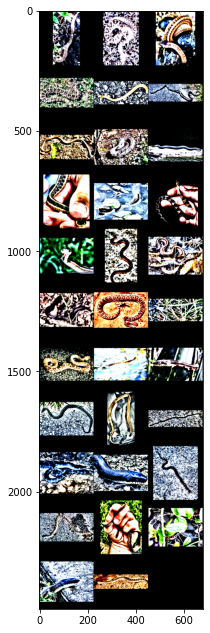

labels: tensor([0, 4, 2, 4, 2, 3, 2, 0, 0, 1, 0, 0, 1, 1, 2, 0, 4, 0, 4, 0, 3, 1, 2, 3,
        3, 3, 0, 3, 2, 0, 3, 4])


In [12]:
data_loader_train,data_loader_test,data_loader_val = transformDS1(32,224)
show_transformed_images(data_loader_val)

In [ ]:
Accuracies=[]
valAccuracies = []
total_steps = len(data_loader_train)
t1 = time.time()
for epoch in range(n_epochs):
    print("Epoch number %d" %(epoch+1))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    resnet18Model.to(device)
    print("Device: {}".format(device))
    resnet18Model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        total += labels.size(0)

        optimizer.zero_grad()
        outputs = resnet18Model(images)
        _,predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            validation_accuracy = 0
            resnet18Model.eval()
            with torch.no_grad(): 
                val_correct = 0
                val_total = 0
                for data in data_loader_val:
                    images, val_labels = data[0].to(device), data[1].to(device)
                    outputs = resnet18Model(images)

                    # Validation set accuracy
                    val_total = val_labels.size(0)
                    _,predicted = torch.max(outputs.data, 1)
                    val_correct += (predicted == val_labels).sum().item()
                    val_total  += val_labels.size(0)

            validation_accuracy = (val_correct / val_total)
            training_accuracy = (running_correct / total) * 100
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
                .format(epoch + 1, n_epochs, i + 1, total_steps, loss.item(), training_accuracy , validation_accuracy))
    scheduler.step()
    epoch_loss = running_loss/len(data_loader_train)
    epoch_accuracy = 100.00 * (running_correct/total)   
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)      
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f"%(epoch_loss,epoch_accuracy))
      
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
torch.save(resnet18Model.state_dict(), "/content/5-class-d1-output.pt")

Epoch number 1
Epoch [1/100], Step [100/381], Loss: 1.6131, Training Accuracy: 27.50%, Validation Accuracy: 26.30%
Epoch [1/100], Step [200/381], Loss: 1.5495, Training Accuracy: 28.59%, Validation Accuracy: 26.30%
Epoch [1/100], Step [300/381], Loss: 1.4450, Training Accuracy: 29.39%, Validation Accuracy: 25.88%
Training Data: Epoch Loss: 1.552, Epoch Accuracy: 30.134
Epoch number 2
Epoch [2/100], Step [100/381], Loss: 1.2884, Training Accuracy: 38.75%, Validation Accuracy: 32.90%
Epoch [2/100], Step [200/381], Loss: 1.5894, Training Accuracy: 36.12%, Validation Accuracy: 27.95%
Epoch [2/100], Step [300/381], Loss: 1.3738, Training Accuracy: 35.04%, Validation Accuracy: 30.02%
Training Data: Epoch Loss: 1.475, Epoch Accuracy: 35.237
Epoch number 3
Epoch [3/100], Step [100/381], Loss: 1.4657, Training Accuracy: 39.81%, Validation Accuracy: 36.05%
Epoch [3/100], Step [200/381], Loss: 1.4980, Training Accuracy: 37.41%, Validation Accuracy: 33.02%
Epoch [3/100], Step [300/381], Loss: 1.47

In [2]:
# print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
torch.save(resnet18Model.state_dict(), "/content/84-class-d1-output.pt")
resnet18Model.eval()
predicted_correct =0
total = 0
with torch.no_grad():
    for data in data_loader_test:
        images,labels = data
        images = images.to(device)
        labels = labels.to(device)
        total+=labels.size(0)
        outputs = resnet18Model(images)
        _,predicted = torch.max(outputs,1)
        predicted_correct += (predicted == labels).sum().item()
epoch_accuracy = 100.0* predicted_correct/total
print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
dict = {'Training': Accuracies, 'Validation': valAccuracies} 
df = pd.DataFrame(dict)
df.to_csv("/content/Accuracies.csv")

NameError: ignored

In [ ]:
# Plotting Accuracies Vs Epochs
plt.plot(range(n_epochs),Accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracies")
plt.title("Training Accuracy Vs Epochs")
plt.show()

In [ ]:
# Plotting Validation Accuracies Vs Train Accuracies on Epochs
plt.plot(range(n_epochs),Accuracies, label="Training")
plt.plot(range(n_epochs),valAccuracies, label="Validation")
plt.xlable("Epochs")
plt.ylabel("Accuracies")
plt.title("Training vs Validation Accuracies")
plt.legend()
plt.show()

In [ ]:
from torchvision.models.resnet import resnet34
#Calculate Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in data_loader_test:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = resnet34(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', ' 2', ' 3', '4')

# Build confusion matrix
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                              display_labels=classes)
disp.plot()

plt.show()